In [ ]:
import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
GPT_CFG_124 = {
    'vocab_size': 50257,
    'emb_dim': 768,
    'context_length': 1024,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

In [ ]:
# Layer normalization
'''
It is used to improve the stability and efficieny of neural net training. It helps reduce vanishing gradients/exploding gradients.
- The outputs of every layer is normalized.
- Main idea is to adjust the output of every layer such that their mean is 0 and variance is 1.
- Used usually before and after the attention layer and once before the output layer.
'''
class LayerNormalization(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5 # epsilon - used to avoid dividing by 0
    self.scale = nn.Parameter(torch.ones(emb_dim)) # scale - trainable param
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # shfit - trainable param

  def forward(self,x):
    mean = x.mean(dim=-1,keepdims=True)
    var = x.var(dim=-1,keepdims=True,unbiased=False) # unbiased is for bessel's correction, True uses bessel's correction
    x_norm = (x-mean)/torch.sqrt(var+self.eps) # standardization by adding epsilon
    return self.scale*x_norm + self.shift

In [ ]:
batch_example = torch.randn((5,768))
print(batch_example)
ln = LayerNormalization(emb_dim=768)
out_ln = ln(batch_example)
print(out_ln)

tensor([[ 0.4839, -0.4756,  0.0416,  ...,  0.3176,  1.5585, -0.0471],
        [-1.1143, -0.5367, -0.8800,  ...,  0.4271, -0.1965, -0.9501],
        [-1.3113,  0.5082, -0.5315,  ..., -0.5662,  2.7062, -0.5160],
        [ 0.5120, -1.8496,  0.4328,  ...,  0.7518, -0.6935,  1.0582],
        [ 0.9423, -0.9940,  0.3481,  ..., -1.2210, -1.2087,  0.3301]])
tensor([[ 0.5657, -0.4123,  0.1149,  ...,  0.3962,  1.6611,  0.0245],
        [-1.1373, -0.5443, -0.8968,  ...,  0.4453, -0.1950, -0.9687],
        [-1.1865,  0.5342, -0.4490,  ..., -0.4818,  2.6128, -0.4343],
        [ 0.5811, -1.8419,  0.4999,  ...,  0.8272, -0.6558,  1.1414],
        [ 0.9083, -1.0542,  0.3061,  ..., -1.2843, -1.2718,  0.2878]],
       grad_fn=<AddBackward0>)


In [ ]:
mean = out_ln.mean(dim=-1,keepdims=True)
var = out_ln.var(dim=-1,unbiased=False,keepdims=True)
print("mean:\n",mean)
print("var:\n",var)

mean:
 tensor([[ 8.0715e-09],
        [ 2.4835e-09],
        [-9.3132e-09],
        [ 6.2088e-10],
        [-9.9341e-09]], grad_fn=<MeanBackward1>)
var:
 tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
# GELU activation function
'''
RELU - max(0,x) has the problem of dead neuron which means that -ve outputs will not have any activations and hence learn nothing.
GELU - x*phi(x) [phi(x) is the standard cdf of x], It is smooth throughout meaning it does not have any dead neuron problem and is differentiable throughout.

'''

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) *
                               (x+0.044715*torch.pow(x,3))
                               )) # phi(x) is approximated using this formula

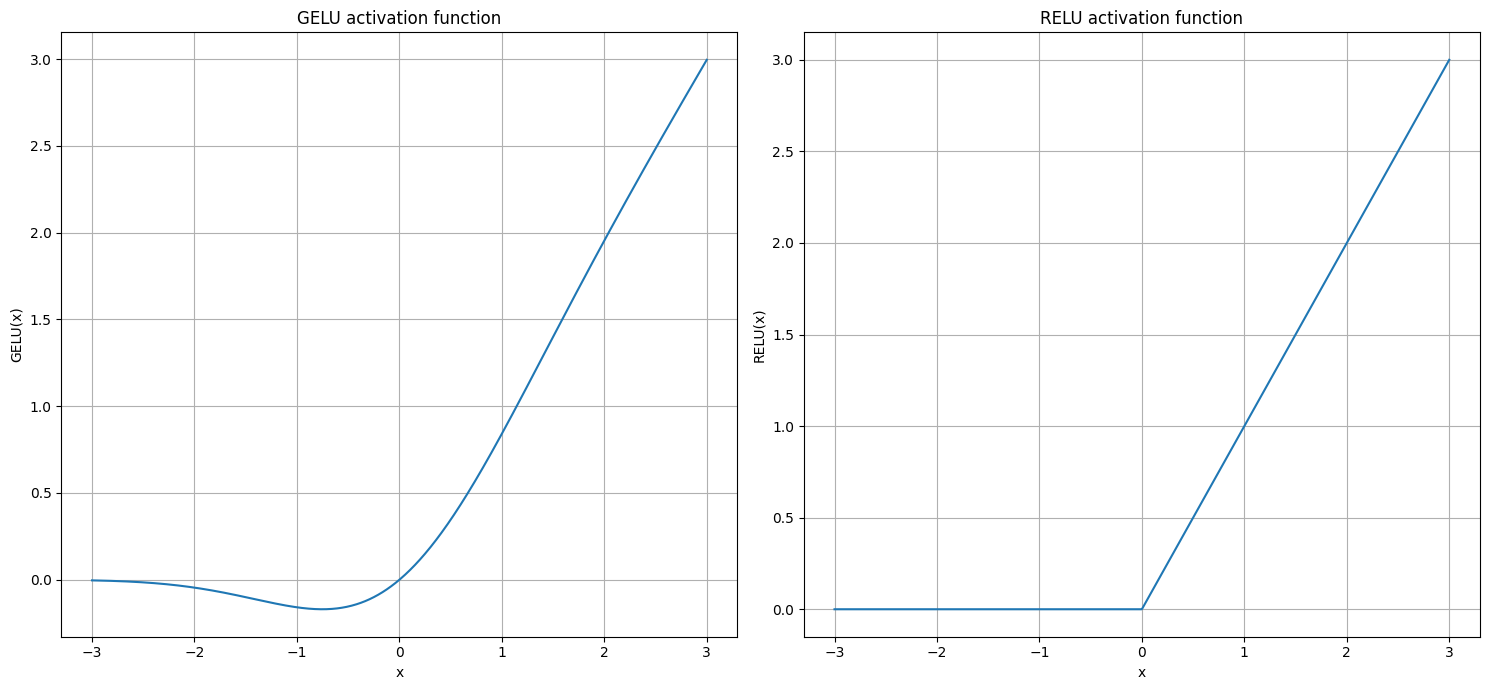

In [ ]:
import matplotlib.pyplot as plt

gelu,relu = GELU(),nn.ReLU()

x = torch.linspace(-3,3,1000)
y_gelu,y_relu = gelu(x),relu(x)

plt.figure(figsize=(15,7))
for i,(y,label) in enumerate(zip([y_gelu,y_relu],["GELU","RELU"]),1): # enumerate(values,counter)
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Feed forward neural network for GPT-2
'''
input: a single token of shape: (1,emb_dim)
operations: the input is expanded into 4x ie projected into a higher dimensional space. Shape: (1,3072)
output: output shape is the same as input shape

'''

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),
        GELU(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])
    )

  def forward(self,x):
    return self.layers(x)

In [ ]:
ffn = FeedForward(GPT_CFG_124)

x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [ ]:
# Shortcut connections/ residual connections

'''
It is used to solve the problem of vanishing gradients. It basically gives the gradients an alternative path to flow.
It's achieved by adding output of one layer to another layer.

'''
class SkipConnections(nn.Module):
  def __init__(self,layers_dim,use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    # Create Linear layers based on provided dimensions in layers_dim
    self.layers = nn.ModuleList([
        nn.Sequential(
            nn.Linear(layers_dim[0], layers_dim[1]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layers_dim[1], layers_dim[0]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layers_dim[2], layers_dim[3]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layers_dim[3], layers_dim[4]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layers_dim[4], layers_dim[5]),
            GELU(),
        ),
    ])

  def forward(self,x):
    for layer in self.layers:
      # calculate output
      out = layer(x)
      # check if shortcut can be applied
      if self.use_shortcut and out.shape==x.shape:
        x = x + out
      # use if not shortcut can be applied
      else:
        x = out

    return x


In [ ]:
# defining model without shortcut
torch.manual_seed(123)
layers_dim = [3,3,3,3,3,1]  # Dimensions for the linear layers
sample = torch.tensor([[1.,0.,-1.]])

model_without_shortcut = SkipConnections(layers_dim,use_shortcut=False)

In [ ]:
# gradient verification without shortcut connections

def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_without_shortcut, sample)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [ ]:
# defining model with shortcut
torch.manual_seed(123)
layers_dim = [3,3,3,3,3,1]  # Dimensions for the linear layers
sample = torch.tensor([[1.,0.,-1.]])

model_with_shortcut = SkipConnections(layers_dim,use_shortcut=True)

In [ ]:
# gradient verification with shortcut connections

def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_with_shortcut, sample)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576
